## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [16]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import copy
import re
import time

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
import torch.optim as optim
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST
from torch.autograd import Variable

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [3]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-12 14:24:09--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-12 14:24:10--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [4]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [5]:
CUDA_DEVICE_ID = 0  # change if needed

In [6]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.2MB/s]


Text(0.5, 1.0, 'Image label: 7')

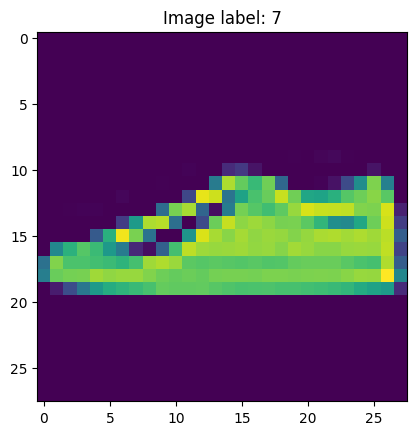

In [7]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [18]:
class FmnistCNN(nn.Module):
    def __init__(self):
        super(FmnistCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  # Добавил padding
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Добавил padding
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Изменил на более стандартные параметры
        )

        # Добавим слой для автоматического вычисления размерности
        self.flatten = nn.Flatten()

        # Временный линейный слой для определения размерности
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(64*7*7, 64),  # Начальное значение (может потребовать корректировки)
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)

        # Если размерность не совпадает, выведем её для отладки
        if self.linear_block[1].in_features != x.size(1):
            print(f"Ошибка размерности! Ожидалось {self.linear_block[1].in_features}, получено {x.size(1)}")
            # Динамически создаём правильный линейный слой
            self.linear_block[1] = nn.Linear(x.size(1), 64).to(x.device)

        x = self.linear_block(x)
        return x

model_task_1 = FmnistCNN()

Не забудьте перенести модель на выбранный `device`!

In [20]:
model_task_1.to(device)

FmnistCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)

Локальные тесты для проверки вашей модели доступны ниже:

In [21]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Ошибка размерности! Ожидалось 3136, получено 12544
Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [22]:
num_epoch = 25
batch_size_train = 32
batch_size_test = 32
learning_rate = 0.002
momentum = 0.9
log_interval = 100

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(params=model_task_1.parameters(), lr=0.001)

exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(1, num_epoch + 1)]

best_model_wts = copy.deepcopy(model_task_1.state_dict())
best_acc = 0.0

since = time.time()

for epoch in range(1, num_epoch + 1):
    model_task_1.train()
    for i, (images, labels) in enumerate(train_data_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_task_1(images)
        # Calculate loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        if (i + 1)% log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (i + 1) * len(images), len(train_data_loader.dataset),
                100. * (i + 1) / len(train_data_loader), loss.data))
            train_losses.append(loss.item())
            train_counter.append((i*64) + ((epoch-1)*len(train_data_loader.dataset)))

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.850971
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.666014
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.575238
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.523188
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.459657
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.495366
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.503357
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.374989
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.615105
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.467814
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.523030
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.428330
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.485396
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.475690
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.417036
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.252773
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.530451
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.294369
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.362380
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.250264
Train E

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [23]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.97552


In [24]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9285


Проверка, что необходимые пороги пройдены:

In [25]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [26]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!